In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
#from torch.optim.lr_scheduler import ReduceLROnPlateau
import medmnist
from medmnist import INFO, Evaluator
from medmnist.dataset import ChestMNIST
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
data_flag = 'chestmnist'
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

In [3]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = DataClass(split='train',transform= data_transform, download = True)
test_dataset = DataClass(split='test',transform= data_transform, download = True)

Using downloaded and verified file: /home/jupyter-bhu22/.medmnist/chestmnist.npz
Using downloaded and verified file: /home/jupyter-bhu22/.medmnist/chestmnist.npz


In [4]:
## Load it into a train and test loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

/opt/tljh/user/lib/python3.9/site-packages/skimage/_shared/utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return func(*args, **kwargs)


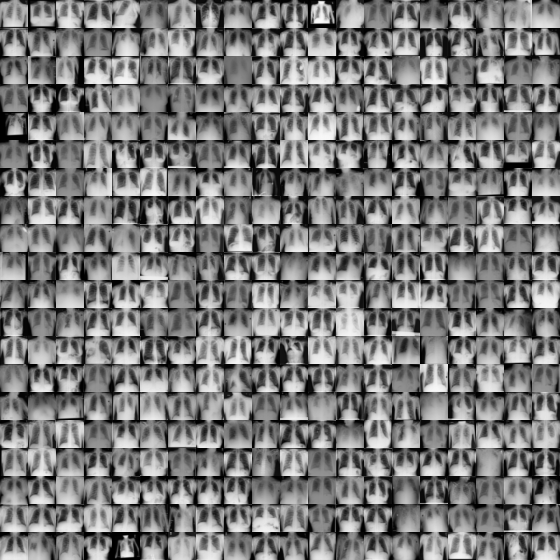

In [5]:
## Visualize training data
train_dataset.montage(length=20)

In [6]:
kernel_size = 5
class autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(n_channels, 6, kernel_size)
        self.conv2 = nn.Conv2d(6, 12, kernel_size)
        self.pool  = nn.MaxPool2d(2, 2)
        self.iconv1 = nn.ConvTranspose2d(12, 6, kernel_size+1, stride = 2)
        self.iconv2 = nn.ConvTranspose2d(6, n_channels, kernel_size+1, stride = 2)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        return x
    
    def decode(self, x):
        x = F.relu(self.iconv1(x))
        ## Use the sigmoid as the final layer 
        ## since we've normalized pixel values to be between 0 and 1
        x = torch.sigmoid(self.iconv2(x))
        return(x)
    
    def forward(self, x):
        return self.decode(self.encode(x))
    
model = autoencoder()

In [7]:
## Here's some example data by grabbing one batch
img_tryItOut, class_tryItOut = iter(train_loader).next()
print(img_tryItOut.shape)

## Let's encode that data
encoded = model.encode(img_tryItOut)
print(encoded.shape)

## Now let's decode the encoded data
decoded = model.decode(encoded)
print(decoded.shape)

# ## Now let's run the whole thing through
fedForward = model.forward(img_tryItOut)
print(fedForward.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128, 12, 4, 4])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


In [8]:
#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

#Epochs
n_epochs = 50

model.train()

training_loss =[]
for epoch in range(n_epochs):
    running_loss = 0.0
    for data, classes in train_loader:
        images = data
        optimizer.zero_grad()
        outputs = model.forward(images)
        loss = F.mse_loss(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
        
    loss = running_loss/len(train_loader)
    training_loss.append(loss)
    print('Epoch {} of {}, Training Loss:{:.5f}'.format(epoch+1, n_epochs, loss))

Epoch 1 of 50, Training Loss:0.17630
Epoch 2 of 50, Training Loss:0.13992
Epoch 3 of 50, Training Loss:0.13626
Epoch 4 of 50, Training Loss:0.13483
Epoch 5 of 50, Training Loss:0.13389
Epoch 6 of 50, Training Loss:0.13339
Epoch 7 of 50, Training Loss:0.13299
Epoch 8 of 50, Training Loss:0.13275
Epoch 9 of 50, Training Loss:0.13246
Epoch 10 of 50, Training Loss:0.13231
Epoch 11 of 50, Training Loss:0.13237
Epoch 12 of 50, Training Loss:0.13203
Epoch 13 of 50, Training Loss:0.13185
Epoch 14 of 50, Training Loss:0.13205
Epoch 15 of 50, Training Loss:0.13179
Epoch 16 of 50, Training Loss:0.13177
Epoch 17 of 50, Training Loss:0.13180
Epoch 18 of 50, Training Loss:0.13153
Epoch 19 of 50, Training Loss:0.13144
Epoch 20 of 50, Training Loss:0.13146
Epoch 21 of 50, Training Loss:0.13137
Epoch 22 of 50, Training Loss:0.13147
Epoch 23 of 50, Training Loss:0.13134
Epoch 24 of 50, Training Loss:0.13136
Epoch 25 of 50, Training Loss:0.13137
Epoch 26 of 50, Training Loss:0.13128
Epoch 27 of 50, Train

# Part 1. Evaluate and compare the training and testing error of the autoencoder

Text(0, 0.5, 'Loss')

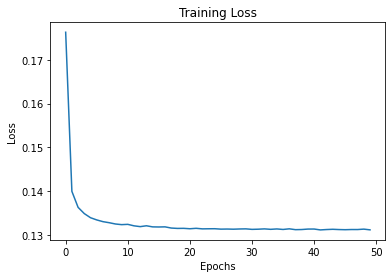

In [9]:
# Training Loss vs Epochs plot
plt.figure()
plt.plot(training_loss)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [10]:
# Training error of the model after 50 epochs 
training_loss[-1]

0.13111419127556323

In [11]:
# Evaluate the testing error of the model 

model.eval()  # set evaluation mode for the model 

with torch.no_grad():
    running_loss = 0.0
    for img, classes in test_loader:
        test_output = model.forward(img)
        loss = F.mse_loss(test_output, img)
        running_loss += loss.item()

    testing_loss = running_loss/len(test_loader)

In [12]:
testing_loss

0.13050529834899036

The training error after 50 epochs is about 0.1311 and the testing error is about 0.1305. The testing error is very close to the training error but a little bit smaller. It shows the generalizability of the model as the model has not seen the testing images before but it could output the images with a relatively small testing error after passing the testing images through the autoencoder. 

# Part 2. Show the result of feeding a few training and testing images through the autoencoder

### Result of training images (Top row: original images, bottom row: images output by the autoencoder)

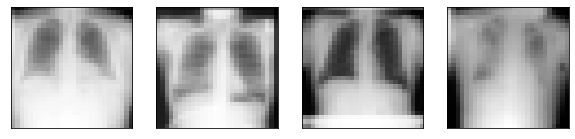

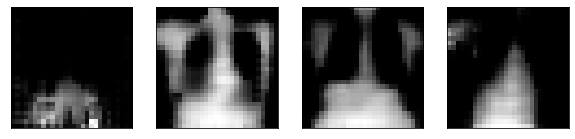

In [13]:
## the data from the last iteration is called images
trainSample = images.detach().numpy()

plt.figure(figsize=(10,5))
for i in range(4): 
    plt.subplot(1, 4,i+1)
    plt.xticks([])
    plt.yticks([])
    img = np.transpose(trainSample[i,:,:,:], (1, 2, 0))
    plt.imshow(img, cmap="gray")

## the output from the last iterations (feed forward through the network) is called outputs
trainOutput = outputs.detach().numpy()

plt.figure(figsize=(10,5))
for i in range(4): 
    plt.subplot(2, 4,i+5)
    plt.xticks([])
    plt.yticks([])
    img = np.transpose(trainOutput[i,:,:,:], (1, 2, 0))
    plt.imshow(img, cmap="gray")

Here shows the result of training images through the autoencoder. The first one only shows very few parts of the diaphram (at the bottom) so it is very different from the original image. The middle two results show the general shape of the person's esophagus(midline) and lungs but are not very detailed as the original ones. For the last result, it's very hard to tell it is a chest ray and it might be due to the fact the lung does not show a good contrast with surrounding structures (the lung is not very clear) in the original image. All output images are blurrier than the original ones. 


### Result of Testing images (Top row: original images, bottom row: images output by the autoencoder)

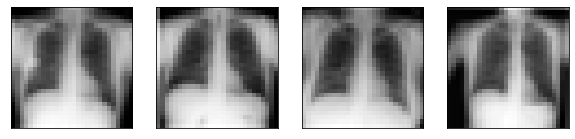

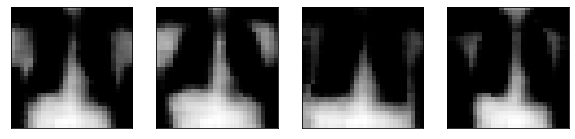

In [14]:
# Obtain one batch of test images, test_sample_input: original test images
# test_sample_output:images output by the autoencoder

test_img, test_classes = iter(test_loader).next()
test_sample_output = model.forward(test_img).detach().numpy() 
test_sample_input = test_img.detach().numpy()

plt.figure(figsize=(10,5))
for i in range(4): 
    plt.subplot(1, 4,i+1)
    plt.xticks([])
    plt.yticks([])
    img = np.transpose(test_sample_input[i,:,:,:], (1, 2, 0))
    plt.imshow(img, cmap="gray")


plt.figure(figsize=(10,5))
for i in range(4): 
    plt.subplot(2, 4,i+5)
    plt.xticks([])
    plt.yticks([])
    img = np.transpose(test_sample_output[i,:,:,:], (1, 2, 0))
    plt.imshow(img, cmap="gray")

As the original test images show a relatively good contrast between each structure such as lung and heart, the output images show basic structures and also general shape of the lungs except the details within the lungs are missing. The output images are blurrier than the original ones.